In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('pubg-prediction')
jovian.set_colab_id('1_GzkPC_NTJQrUapi33BVuErixlPKI8YO')

     |████████████████████████████████| 68 kB 3.2 MB/s 


## Introduction

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.thenfapost.com%2Fwp-content%2Fuploads%2F2020%2F07%2FPUBG.jpg&f=1&nofb=1" alt="Pubg Poster" title="Pubg" width="1100" height="900"/>



PUBG is a player versus player shooter game in which up to one hundred players fight in a battle royale, a type of large-scale last man standing deathmatch where players fight to remain the last alive. Players can choose to enter the match solo, duo, or with a small team of up to four people. The last person or team alive wins the match.

Each match starts with players parachuting from a plane onto one of the four map. The plane's flight path across the map varies with each round, requiring players to quickly determine the best time to eject and parachute to the ground. Players start with no gear beyond customized clothing selections which do not affect gameplay. Once they land, players can search buildings, ghost towns and other sites to find weapons, vehicles, armor, and other equipment. These items are procedurally distributed throughout the map at the start of a match, with certain high-risk zones typically having better equipment. Killed players can be looted to acquire their gear as well. Players can opt to play either from the first-person or third-person perspective, each having their own advantages and disadvantages in combat and situational awareness; though server-specific settings can be used to force all players into one perspective to eliminate some advantages.

Every few minutes, the playable area of the map begins to shrink down towards a random location, with any player caught outside the safe area taking damage incrementally, and eventually being eliminated if the safe zone is not entered in time; in game, the players see the boundary as a shimmering blue wall that contracts over time. This results in a more confined map, in turn increasing the chances of encounters. During the course of the match, random regions of the map are highlighted in red and bombed, posing a threat to players who remain in that area. In both cases, players are warned a few minutes before these events, giving them time to relocate to safety. A plane will fly over various parts of the playable map occasionally at random, or wherever a player uses a flare gun, and drop a loot package, containing items which are typically unobtainable during normal gameplay. These packages emit highly visible red smoke, drawing interested players near it and creating further confrontations. On average, a full round takes no more than 30 minutes. 

## Problem Statement

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place). 

## Importing the libraries

Before importing let's install all the libraries that are going to be used in the notebook.

In [2]:
pip install numpy pandas matplotlib seaborn sklearn opendatasets xgboost --quiet

In [3]:
import os
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)


## Downloading the data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library.

The dataset is available at https://www.kaggle.com/c/pubg-finish-placement-prediction/data

In [4]:
od.download('https://www.kaggle.com/c/pubg-finish-placement-prediction/data') # downloading the dataset by providing the url

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kaustubhlande
Your Kaggle Key: ··········


100%|██████████| 361M/361M [00:03<00:00, 110MB/s]



Extracting archive ./pubg-finish-placement-prediction/pubg-finish-placement-prediction.zip to ./pubg-finish-placement-prediction


The dataset is downloaded and extracted to the folder `pubg-finish-placement-prediction`.

In [5]:
os.listdir('pubg-finish-placement-prediction') # list of files in the pubg-finish-placement-prediction directory

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']

The file `train_V2.csv` contains the train data. 

The file `test_V2.csv` contains the test data.

Let's load it into a Pandas dataframe.

## Reading the dataset

In [ ]:
train_df = pd.read_csv('pubg-finish-placement-prediction/train_V2.csv') # reading the training data
test_df = pd.read_csv('pubg-finish-placement-prediction/test_V2.csv') # reading the testing data

## Feature Description:

1. DBNOs - Number of enemy players knocked.
2. assists - Number of enemy players this player damaged that were killed by teammates.
3. damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
4. headshotKills - Number of enemy players killed with headshots.
5. heals - Number of healing items used.
6. Id - Player’s Id
7. killPlace - Ranking in match of number of enemy players killed.
8. killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
9. killStreaks - Max number of enemy players killed in a short amount of time.
10. kills - Number of enemy players killed.
11. longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
12. matchDuration - Duration of match in seconds.
13. matchId - ID to identify match. There are no matches that are in both the training and testing set.
14. matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
15. rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
16. revives - Number of times this player revived teammates.
17. rideDistance - Total distance traveled in vehicles measured in meters.
18. roadKills - Number of kills while in a vehicle.
19. swimDistance - Total distance traveled by swimming measured in meters.
20. teamKills - Number of times this player killed a teammate.
21. vehicleDestroys - Number of vehicles destroyed.
22. walkDistance - Total distance traveled on foot measured in meters.
23. weaponsAcquired - Number of weapons picked up.
24. winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
25. groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
26. numGroups - Number of groups we have data for in the match.
27. maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
28. boosts - Number of boost items used.
29. winPlacePerc - The target of prediction. 
This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [ ]:
train_df.head() # first 5 rows of training data

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


Each record shows the individual performance of the players with respect to different aspect of the matches.

In [ ]:
test_df.head() # first 5 rows of testing data

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,0,0,0,0.00,1884,squad-fpp,28,28,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,0,2,1,361.90,1811,duo-fpp,48,47,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,0,0,0,0.00,1793,squad-fpp,28,27,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,0,0,0,0.00,1834,duo-fpp,45,44,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,0,3,1,60.06,1326,squad-fpp,28,27,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [ ]:
print('The training data has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print('The test data has {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

The training data has 4446966 rows and 29 columns
The test data has 1934174 rows and 28 columns


Let's take a look at the datatypes of the column present in the dataset.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

Except `matchType` all the other columns are of numerical datatypes while `matchType` is of the type object.

In [ ]:
train_df.describe() # descriptive statisitics of train data

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [ ]:
train_df.isna().sum() # sum of na values in train data

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [ ]:
test_df.isna().sum() # sum of na values in train data

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

We can delete the missing record since `winPlacePerc` is the target feature and it cannot be used for prediction.

In [ ]:
train_df.dropna(inplace = True) # dropping na values

## Exploratory Data Analysis 

Let's explore to dataset to find some insights that can be used building the ML models.

### MatchType:

There are 3 modes available in PUBG. One can play `solo`, or with a friend `(duo)`, or with 3 other friends `(squad)`. 

<AxesSubplot:>

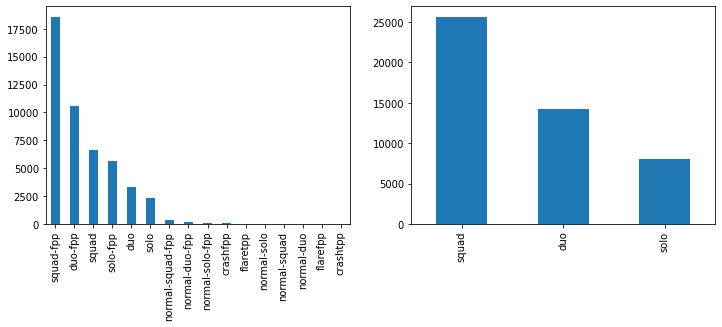

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train_df.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'

train_df['matchType'] = train_df['matchType'].apply(mapper)

train_df.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

### MaxPlace, NumGroups

__NumGroups :__ Number of groups we have data for in the match.

__MaxPlace :__ Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

In [ ]:
cols = ['numGroups','maxPlace']
des1 = train_df.groupby('matchType')[cols].agg(['min','mean','max']) # getting the 'min','mean','max' values of the grouped data
group = train_df.groupby(['matchType','matchId','groupId']).count().groupby(['matchType','matchId']).size().to_frame('Groups in match')
des2 = group.groupby('matchType')['Groups in match'].agg(['min','mean','max'])
pd.concat([des1, des2], axis = 1) # concatenating the two sets of grouped data

,"(numGroups, min)","(numGroups, mean)","(numGroups, max)","(maxPlace, min)","(maxPlace, mean)","(maxPlace, max)",min,mean,max
matchType,,,,,,,,,
duo,1,45.812482,52,3,47.608919,52,1,45.348777,52
solo,1,91.115282,100,2,93.908900,100,1,85.679886,100
squad,2,27.039389,37,2,27.982982,37,2,26.834984,37


In [ ]:
match = train_df.groupby(['matchType', 'matchId']).size().to_frame('players in match')
group = train_df.groupby(['matchType', 'matchId', 'groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').agg(['min', 'mean', 'max']), 
           group.groupby('matchType').agg(['min', 'mean', 'max'])], axis = 1)

players in match                 players in group              
                       min       mean  max              min      mean max
matchType                                                                
duo                      7  92.985658  100                1  2.050456  72
solo                     2  89.042748  100                1  1.039249  64
squad                    5  93.723193  100                1  3.492575  74

### MatchDuration:

MatchDuration represents the duration of match in seconds.

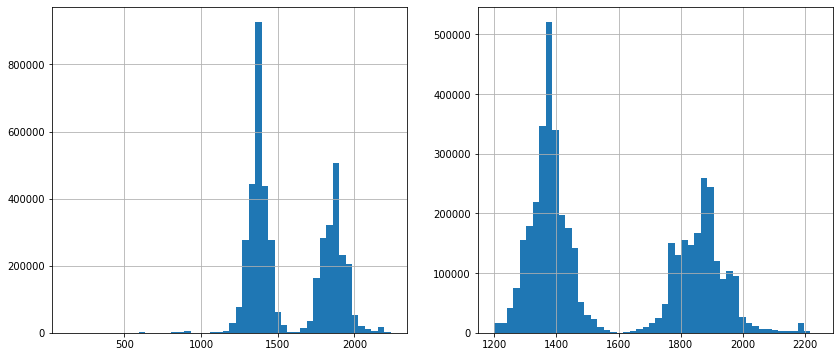

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14,6))

# plotting the distribution of the MatchDuration column
train_df['matchDuration'].hist(bins = 50, ax = ax[0])
train_df.query('matchDuration>=1200')['matchDuration'].hist(bins = 50, ax = ax[1]) # plotting the distribution of the MatchDuration were values are greater than 1200
plt.show();

### Assists:

Assist means to help, In PUBG if you have given damage to the enemy and your team-mate kills the same enemy as you have done some damage on it then it is counted as Assist Kill as both you and your team-mate as taken down the enemy.

(Or)

__Assists :__ Number of enemy players this player damaged that were killed by teammates.

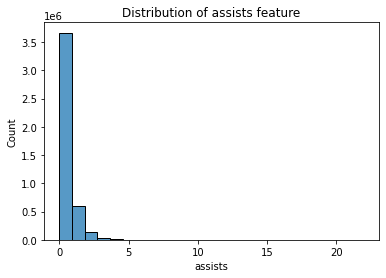

In [ ]:
# distribution of assists column
sns.histplot(x = 'assists', data = train_df)
plt.title('Distribution of assists feature')# title
plt.show();

Here we can see that the distribution is right skewed which needs to be processed to make a normal distribution.

### Boosts:

There are three booster items in PUBG: Energy Drinks, Painkillers and Adrenaline Shots. These all increase your booster bar. Fill up your booster bar and it'll slowly replenish your health over time. The more it's full, the faster the health regeneration.

__Boosts :__ Number of boost items used.

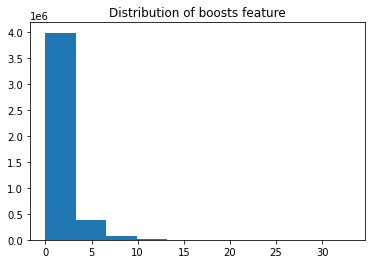

In [ ]:
# distribution of assists column
plt.hist(x = 'boosts', data = train_df)
plt.title('Distribution of boosts feature')# title
plt.show();

Here also we can see that the distribution is right skewed which needs to be processed to make a normal distribution.

### DamageDealt

__DamageDealt :__ Total damage dealt. Note: Self inflicted damage is subtracted.

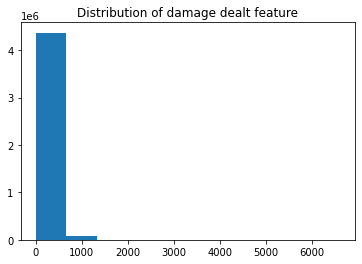

In [ ]:
plt.hist(x = 'damageDealt', data = train_df)
plt.title('Distribution of damage dealt feature')# title
plt.show();

Here also we can see that the distribution is right skewed which needs to be processed to make a normal distribution.

Let's loop through all numeric columns to explore the distributions.

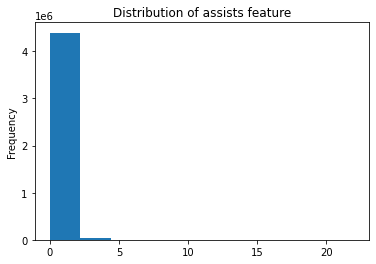

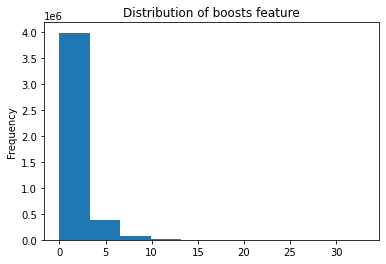

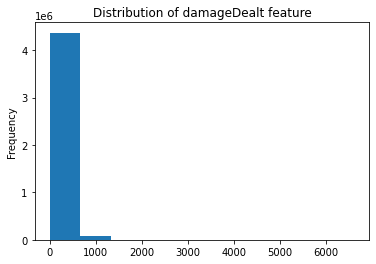

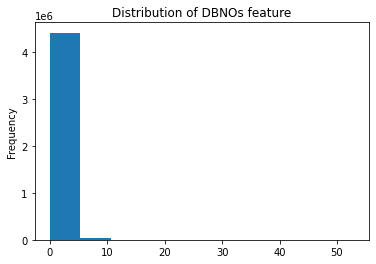

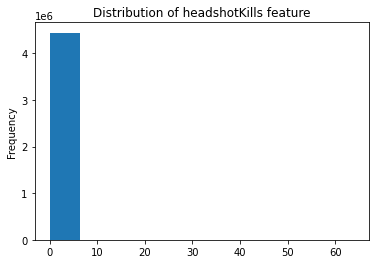

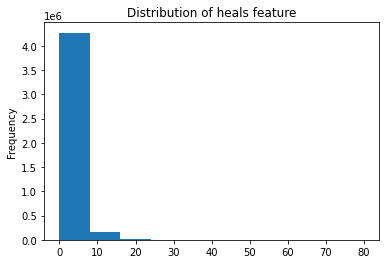

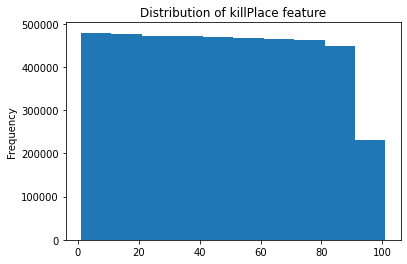

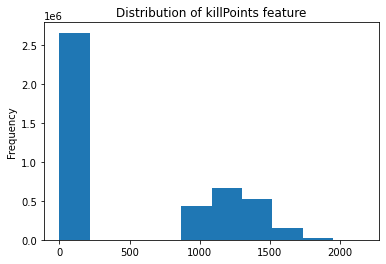

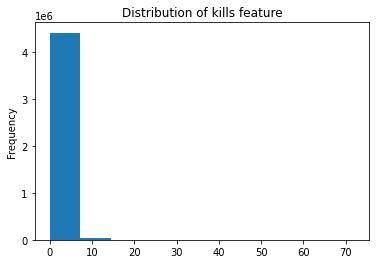

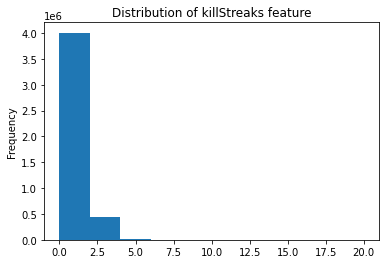

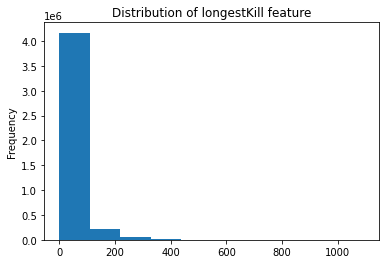

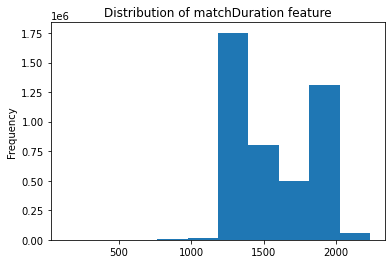

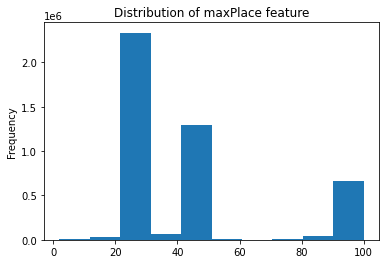

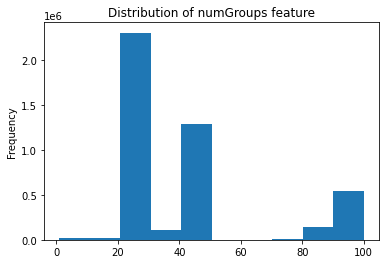

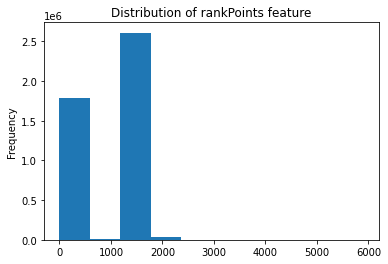

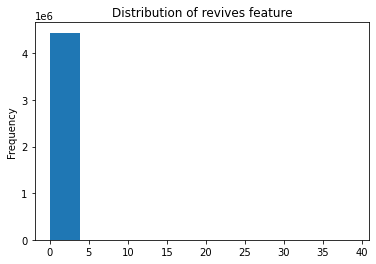

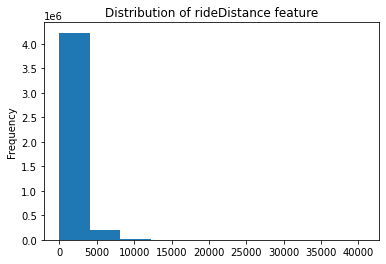

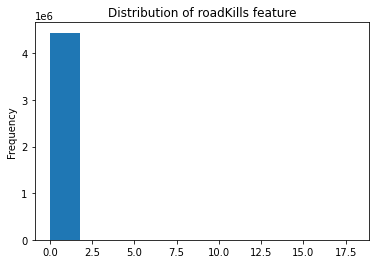

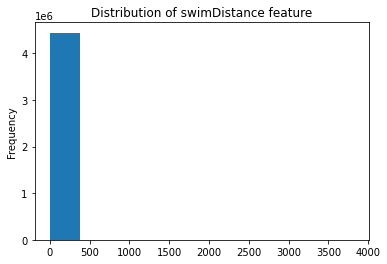

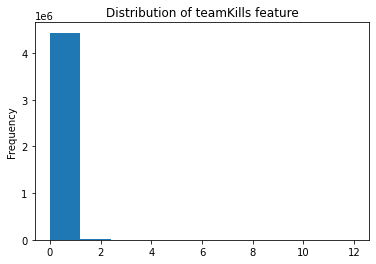

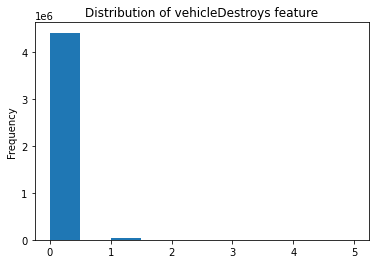

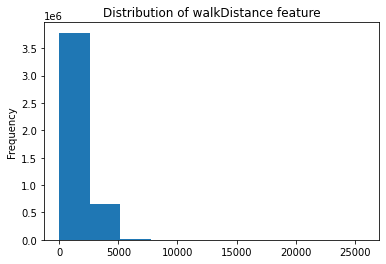

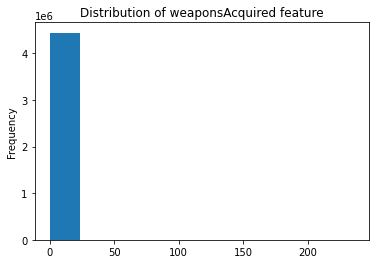

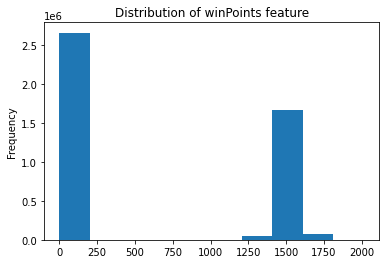

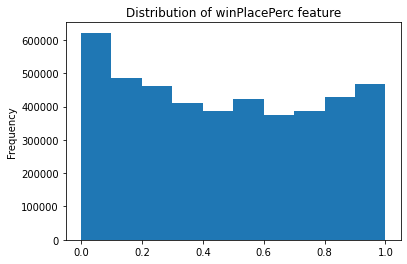

In [ ]:
for col in train_df.select_dtypes(exclude = 'object').columns:
    train_df[col].plot(kind = 'hist')
    plt.title('Distribution of {} feature'.format(col))
    plt.show();

We can see that most of the columns are not normally distributed which might affect the final predictions.

### Correlation between features

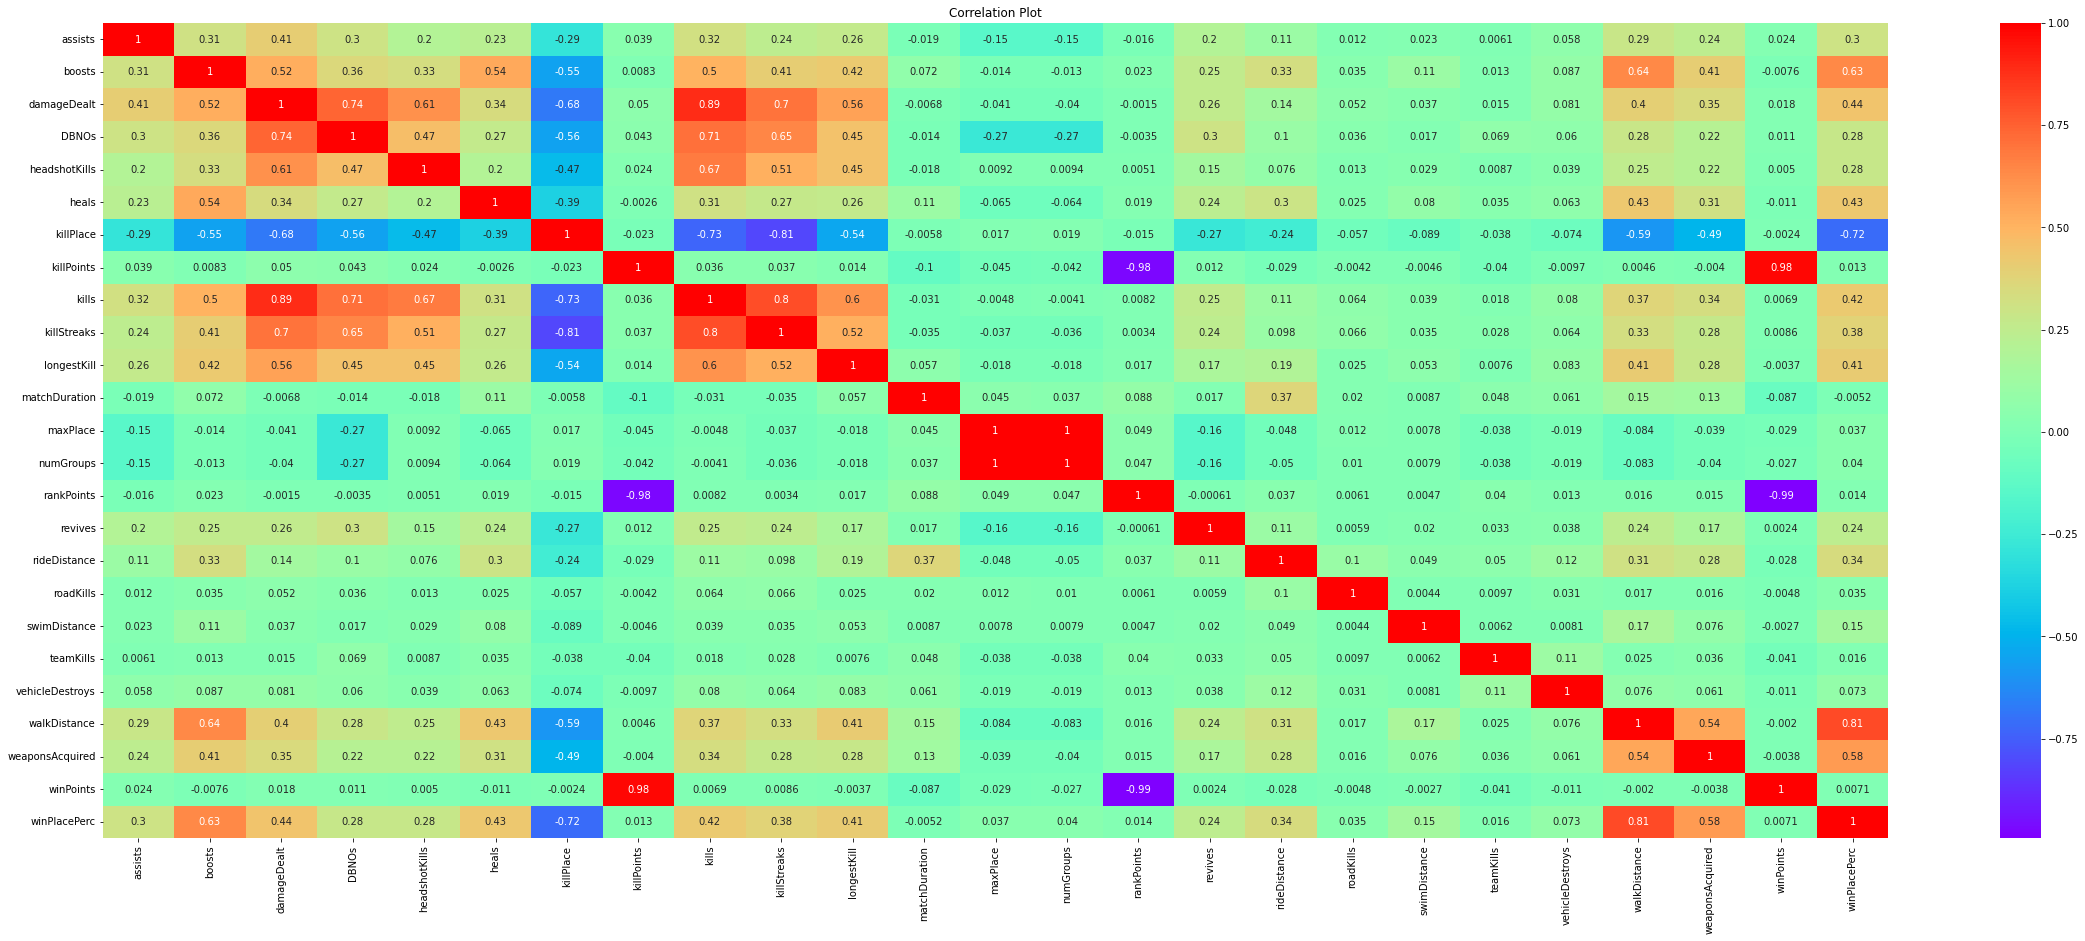

In [ ]:
plt.figure(figsize = (40,15))

plt.title('Correlation Plot') # title
sns.heatmap(train_df.corr(), annot = True, cmap = 'rainbow') # heatmap to visualize the correlation
plt.show();

Here we can see thar with repect to the `winPlacePerc` features like `boosts`, `walkDistance`,`weaponsAcquired`, etc have a positive correlation.

## Feature Engineering

### HealthItems

We can add the value of `heals` and `boosts` column and create a new column `items`.

In [ ]:
train_df['health_items'] = train_df['heals'] + train_df['boosts']
test_df['health_items'] = test_df['heals'] + test_df['boosts']

# dropping the duplicate columns
#train_df.drop(columns = ['heals', 'boosts'], axis = 1, inplace = True)
#test_df.drop(columns = ['heals', 'boosts'], axis = 1, inplace = True)

### TotalDistance

Creating a new column `totalDistance` as a summation of `rideDistance`, `swimDistance`, `walkDistance`

In [ ]:
train_df['totalDistance'] = train_df['rideDistance'] + train_df['swimDistance'] + train_df['walkDistance']
test_df['totalDistance'] = test_df['rideDistance'] + test_df['swimDistance'] + test_df['walkDistance']

# dropping the duplicate columns
#train_df.drop(columns = ['rideDistance', 'swimDistance', 'walkDistance'], axis = 1, inplace = True)
#test_df.drop(columns = ['rideDistance', 'swimDistance', 'walkDistance'], axis = 1, inplace = True)

### KillsWithoutMoving

Creating a new column `killsWithoutMoving` using the `kills` and `totalDistance` columns to find the number of kills a player made without any movement.

In [ ]:
train_df['killsWithoutMoving'] = ((train_df['kills'] > 0) & (train_df['totalDistance'] == 0))
test_df['killsWithoutMoving'] = ((test_df['kills'] > 0) & (test_df['totalDistance'] == 0))

### Teamwork

Creating a new column `teamwork` as a summation of `assists` and `revives`

In [ ]:
train_df['teamwork'] = train_df['assists'] + train_df['revives']
test_df['teamwork'] = test_df['assists'] + test_df['revives']

# dropping the duplicate columns
#train_df.drop(columns = ['assists', 'revives'], axis =1, inplace = True)
#test_df.drop(columns = ['assists', 'revives'],axis =1, inplace = True)

### HeadShotKillRate

Calculating the rate of headshot kills and saving it as `headshot_kill_rate`

In [ ]:
train_df['headshot_kill_rate'] = train_df['headshotKills'] / train_df['kills']
test_df['headshot_kill_rate'] = test_df['headshotKills'] / test_df['kills']

# replacing nan values with 0 in train and test
train_df.replace(np.nan, 0, inplace = True)
test_df.replace(np.nan, 0, inplace = True)

# dropping the duplicate columns
#train_df.drop(columns = ['headshotKills', 'kills'], axis =1, inplace = True)
#test_df.drop(columns = ['headshotKills', 'kills'],axis =1, inplace = True)

In [ ]:
# applying the already defined mapper function on the test data

test_df['matchType'] = test_df['matchType'].apply(mapper)

## Outlier Removal

### Kills without moving

It is impossible to kill the players without moving unless the player uses some kind of cheating methods. So we can consider those points as outliers.

In [ ]:
# getting the index of all the players who have kills_without_moving as True

idx_to_drop = train_df[train_df['killsWithoutMoving'] == True].index
len(idx_to_drop)

1535

In [ ]:
train_df.drop(index = idx_to_drop, inplace = True) # dropping the rows were players having kills_without_moving as True

#### Roadkills

In [ ]:
train_df['roadKills'].unique() # all the unique values in the roadkills columns

array([ 0,  1,  2,  3,  4,  5,  6,  8,  7,  9, 14, 11, 18, 10])

In [ ]:
train_df[train_df['roadKills'] >= 10] # getting the rows were the roadkills values are greater than or equal to 10

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,health_items,totalDistance,killsWithoutMoving,teamwork,headshot_kill_rate
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,1403,14,13,7.181,1456,solo,92,80,-1,0,0.005,14,5.297,0,0,1277.00,0,1371,0.4286,0,1282.302,False,0,0.000000
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,1497,11,11,0.000,1946,solo,88,77,-1,0,4118.000,11,0.000,0,0,816.60,5,1533,0.4713,0,4934.600,False,0,0.000000
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,1114,20,18,64.290,1970,solo,38,20,-1,0,2726.000,18,0.000,0,0,3150.00,4,1568,1.0000,19,5876.000,False,0,0.050000
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,1520,18,11,341.400,1925,solo,84,70,-1,0,6812.000,11,0.000,0,0,1041.00,10,1606,0.9398,10,7853.000,False,0,0.277778
3954337,4228347e428b79,77ea5e30cffe9a,7c9ba5f5267e54,0,0,1000.0,0,0,0,2,1350,10,10,0.000,1992,solo,93,81,-1,0,577.600,10,0.000,0,0,86.48,0,1398,0.2174,0,664.080,False,0,0.000000
4194275,ef242233f0c1f1,52d3feee3ff6d6,c35eb4e9d58f7c,1,1,685.4,3,0,2,1,0,10,2,4.377,886,duo,46,41,1500,0,3751.000,10,0.000,0,0,737.00,1,0,1.0000,3,4488.000,False,1,0.000000


Here we can see that player c3e444f7d1289d drove 5 meters but killed 14 people with it. Which doesn't make sense.

In [ ]:
# dropping all the rows were the roadKills values are greater than or eqaul to 10

idx_to_drop = train_df[train_df['roadKills'] >= 10].index
train_df.drop(index = idx_to_drop, inplace = True)

#### Kills

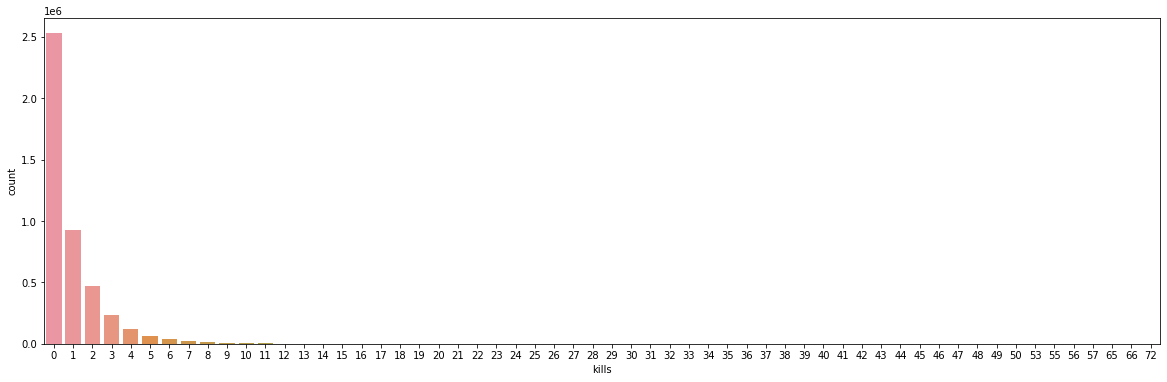

In [ ]:
plt.figure(figsize = (20, 6))
sns.countplot(train_df['kills']) # countplot of the kills columns
plt.show()

We can see that the maximum number of kills for a single player goes upto 72 which is not possible. Any number of kills above 20 can be consisered as outliers.

In [ ]:
# dropping all the rows wew the kills values are greater than 20

idx_to_drop = train_df[train_df['kills'] > 20].index
train_df.drop(index = idx_to_drop, inplace = True)

#### Longest Kill

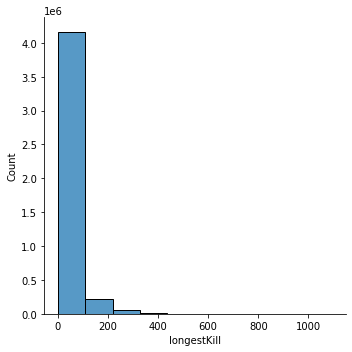

In [ ]:
# checking the distribution of longestKill column

sns.displot(train_df['longestKill'], bins=10)
plt.show()

We can see that the maximum kill distance is 1km which is not normal. So we can consider them as outliers and drop them.

In [ ]:
# dropping the rows were the longestKill is greater than or equal to 1000

idx_to_drop = train_df[train_df['longestKill'] >= 1000].index
train_df.drop(index = idx_to_drop, inplace = True)

#### Distance travelled

In [ ]:
train_df[['walkDistance', 'rideDistance', 'swimDistance', 'totalDistance']].describe()

,walkDistance,rideDistance,swimDistance,totalDistance
count,4.444989e+06,4.444989e+06,4.444989e+06,4.444989e+06
mean,1.154644e+03,6.063346e+02,4.510920e+00,1.765490e+03
std,1.183519e+03,1.498592e+03,3.050230e+01,2.183277e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.554000e+02,0.000000e+00,0.000000e+00,1.584000e+02
50%,6.864000e+02,0.000000e+00,0.000000e+00,7.893000e+02
75%,1.977000e+03,2.586000e-01,0.000000e+00,2.729000e+03
max,2.578000e+04,4.071000e+04,3.823000e+03,4.127010e+04


<AxesSubplot:xlabel='walkDistance', ylabel='Count'>

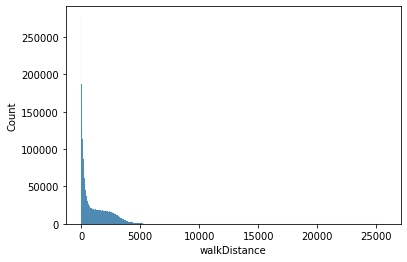

In [ ]:
## walk distance
sns.histplot(train_df['walkDistance'])

In [ ]:
# dropping the rows were the walkDistance is greater than or equal to 10000

idx_to_drop = train_df[train_df['walkDistance'] >= 10000].index
train_df.drop(index = idx_to_drop, inplace = True)

In [ ]:
# dropping the rows were the rideDistance is greater than or equal to 20000

idx_to_drop = train_df[train_df['rideDistance'] >= 20000].index
train_df.drop(index = idx_to_drop, inplace = True)

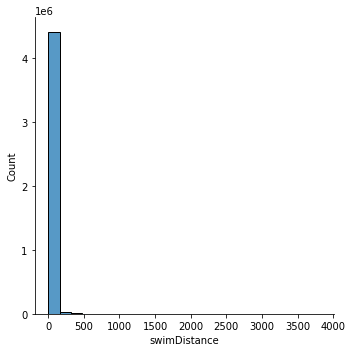

In [ ]:
## swin distance
sns.displot(train_df['swimDistance'])

In [ ]:
# dropping the rows were the swimDistance is greater than or equal to 2000

idx_to_drop = train_df[train_df['swimDistance'] >= 2000].index
train_df.drop(index = idx_to_drop, inplace = True)

#### Weapons Acquired

<Figure size 864x288 with 0 Axes>

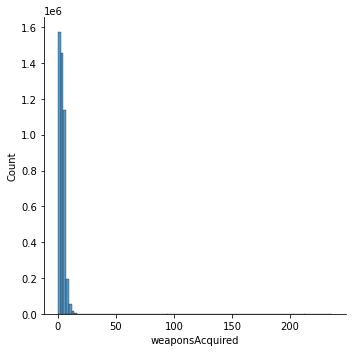

In [ ]:
plt.figure(figsize=(12,4))
sns.displot(train_df['weaponsAcquired'], bins=100) # distribution of weapons acquired
plt.show()

In [ ]:
train_df['weaponsAcquired'].unique() # unique values of weaponsAcquired column

array([  1,   5,   2,   3,   6,   4,   9,   7,   0,   8,  11,  10,  13,
        14,  43,  15,  12,  28,  16,  21,  18,  25,  26,  19,  24,  23,
        20,  17,  30,  36,  38,  34,  46,  29,  50,  52,  22,  27,  48,
        41,  44,  37,  61,  42,  39,  63,  31,  35,  55,  32,  67,  49,
        40, 128,  47,  33,  56,  70,  45,  80,  64,  51,  72,  59,  62,
       102,  95,  53,  54,  96,  57, 167, 177, 153,  75,  87,  85, 236,
        60,  74,  78,  73,  81,  97,  92])

In [ ]:
# dropping the rows were the weaponsAcquired is greater than or equal to 50

idx_to_drop = train_df[train_df['weaponsAcquired'] >= 50].index
train_df.drop(index = idx_to_drop, inplace = True)

#### Heals

<Figure size 864x288 with 0 Axes>

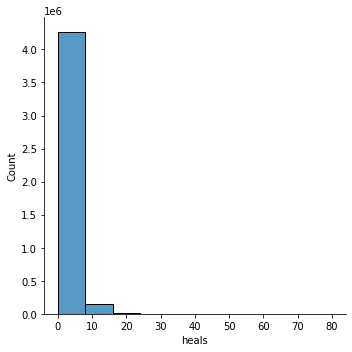

In [ ]:
plt.figure(figsize=(12,4))
sns.displot(train_df['heals'], bins=10) # distribution of heals column
plt.show()

In [ ]:
# dropping the rows were the heals is greater than or equal to 40

idx_to_drop = train_df[train_df['heals'] >= 40].index
train_df.drop(index = idx_to_drop, inplace = True)

In [ ]:
# dropping all the duplicate rows

cols_to_drop = ['heals', 'boosts','rideDistance', 'swimDistance', 'walkDistance', 'assists', 'revives', 'headshotKills', 'kills']
train_df.drop(cols_to_drop, axis = 1, inplace = True)
test_df.drop(cols_to_drop, axis = 1, inplace = True)

## Preparing the data for training

We'll perform the following steps to prepare the dataset for training:

* Create a train/test/validation split.
* Identify input and target columns.
* Identify numeric and categorical columns.
* Impute (fill) missing numeric values.
* Scale numeric values.
* Encode categorical columns to one-hot vectors.

In [ ]:
# dropping the id columns in the train data

train_id_cols = train_df[['Id', 'groupId', 'matchId']]
train_df.drop(columns = ['Id', 'groupId', 'matchId'], inplace = True)

### Encoding the categorical features

Since ML models cannot process categorical data we need to tranform those data to numerical data.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder() # instance of OneHotEncoder
encoder.fit(train_df[['matchType']]) # fitting on the matchType column
encoder.categories_ 

[array(['duo', 'solo', 'squad'], dtype=object)]

In [ ]:
one_hot = encoder.transform(train_df[['matchType']]).toarray() # transforming the matchType column to encoded column
one_hot

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [ ]:
train_df[['duo', 'solo', 'squad']] = one_hot # creating new features that represent the encoded features
train_df.drop(columns = ['matchType'], inplace = True) # dropping the matchType column

Since our training dataset 4446966 rows to simply the training process we can take a random sample from the data to reduce the overall training time of the model.

In [ ]:
np.random.seed(42) # setting seed to have the same randomness
sample_size = 500000 # sample size of 500000
data = train_df.sample(sample_size) # new dataframe of the sampled data
data.head()

,damageDealt,DBNOs,killPlace,killPoints,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,winPlacePerc,health_items,totalDistance,killsWithoutMoving,teamwork,headshot_kill_rate,duo,solo,squad
1718114,0.00,0,74,0,0,0.0,1407,48,47,1517,0,0,0,2,0,0.2128,0,69.13,False,0,0.0,1.0,0.0,0.0
2620424,49.35,0,59,0,0,0.0,1938,28,28,1500,0,0,0,5,0,0.4444,4,5467.00,False,0,0.0,0.0,0.0,1.0
468002,47.36,0,62,1418,0,0.0,1915,28,26,-1,0,0,0,3,1462,0.2593,0,1007.00,False,1,0.0,0.0,0.0,1.0
3124682,92.34,0,42,1473,0,0.0,1369,47,44,-1,0,0,0,5,1492,0.7391,1,2461.00,False,0,0.0,1.0,0.0,0.0
2706785,41.20,0,97,1499,0,0.0,1414,97,94,-1,0,0,0,1,1562,0.0000,0,23.20,False,0,0.0,0.0,1.0,0.0


### Sepeating the depending and independent features.

Before building the ML model it is necessary to split the data so we can have two sets of data that helps us to have a comparison on the results produced by the model.

In [ ]:
X = data.drop('winPlacePerc', axis = 1) # independent features
y = data['winPlacePerc'] # dependent features

In [ ]:
# list of all numeric cols
numeric_cols = X.select_dtypes(exclude = 'object').columns.tolist()

# list of all categorical cols
cat_cols = X.select_dtypes(include = 'object').columns.tolist()

In [ ]:
X[numeric_cols].head()

,damageDealt,DBNOs,killPlace,killPoints,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,health_items,totalDistance,killsWithoutMoving,teamwork,headshot_kill_rate,duo,solo,squad
1718114,0.00,0,74,0,0,0.0,1407,48,47,1517,0,0,0,2,0,0,69.13,False,0,0.0,1.0,0.0,0.0
2620424,49.35,0,59,0,0,0.0,1938,28,28,1500,0,0,0,5,0,4,5467.00,False,0,0.0,0.0,0.0,1.0
468002,47.36,0,62,1418,0,0.0,1915,28,26,-1,0,0,0,3,1462,0,1007.00,False,1,0.0,0.0,0.0,1.0
3124682,92.34,0,42,1473,0,0.0,1369,47,44,-1,0,0,0,5,1492,1,2461.00,False,0,0.0,1.0,0.0,0.0
2706785,41.20,0,97,1499,0,0.0,1414,97,94,-1,0,0,0,1,1562,0,23.20,False,0,0.0,0.0,1.0,0.0


### Performing Train Test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42) # setting validation data size as 20% of the data

### Scaling the numerical features

Since the numerical features in the training data are represented in different scales, it is important to scale to the data so that all the data are of the same scale.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # instance of StandardScaler

In [ ]:
X_train_scaled = scaler.fit_transform(X_train) # fitting and transforming the training data
X_val_scaled = scaler.transform(X_val) # transforming the validation data

## Model 1

The first model that I am going to train is a RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
model1 = RandomForestRegressor(n_jobs = -1, random_state = 100) # instance of RandomForestRegressor
model1.fit(X_train_scaled, y_train) # training the model

RandomForestRegressor(n_jobs=-1, random_state=100)

In [ ]:
# making the predictions for X_train data

train_preds1 = model1.predict(X_train_scaled)
train_preds1

array([0.233814, 0.328076, 0.185429, ..., 0.142195, 0.308684, 0.04308 ])

In [ ]:
# error on the train data

train_rmse1 = mean_squared_error(train_preds1, y_train, squared = False)
print('The RMSE loss for the training data is {}'.format(train_rmse1))

The RMSE loss for the training data is 0.034204378025085934


In [ ]:
# making predictions in the validation data

val_preds1 = model1.predict(X_val_scaled)
val_preds1

array([0.815996, 0.51168 , 0.049088, ..., 0.550839, 0.847474, 0.313068])

In [ ]:
# checking the error on the validation data

val_rmse1 = mean_squared_error(val_preds1, y_val, squared = False)
print('The RMSE loss for the validation data is {}'.format(val_rmse1))

The RMSE loss for the validation data is 0.09119824104093802


In [ ]:
# finding the feature importance so we can know the importance of the features used by the model

# creating a dataframce to represent the feature importance
feature_imp = pd.DataFrame({
    'Feature' : X_train.columns,
    'Importance' : model1.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feature_imp.head(10) # top 10 importance features

,Feature,Importance
16,totalDistance,0.654366
2,killPlace,0.217832
6,matchDuration,0.025393
8,numGroups,0.021144
7,maxPlace,0.011513
4,killStreaks,0.011451
0,damageDealt,0.010138
5,longestKill,0.008220
9,rankPoints,0.007168
15,health_items,0.006726


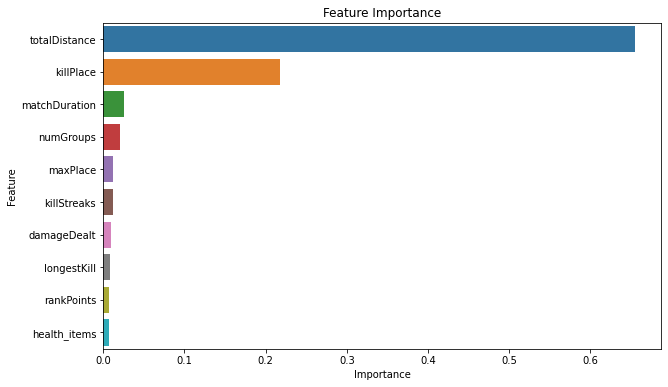

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data = feature_imp.head(10), x = 'Importance', y = 'Feature');

### Hyper-Parameter Tuning

* In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. 
* A hyperparameter is a parameter whose value is used to control the learning process.

In [ ]:
# function that takes the different arguments and trains the RandomForestRegressor
# return the rmse of the training and validation data

def test_params(**params):
    model = RandomForestRegressor(random_state = 100, n_jobs = -1, **params).fit(X_train_scaled, y_train)
    train_rmse = mean_squared_error(model.predict(X_train_scaled), y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val_scaled), y_val, squared=False)
    return train_rmse, val_rmse

In [ ]:
# funcition to plot the training and validation error for the passed parameters
# using the test_params to find the training and validation error

def test_param_and_plot(param_name, param_values):
    train_rmse_ls, val_rmse_ls = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_rmse_ls.append(train_rmse)
        val_rmse_ls.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_rmse_ls, 'b-o')
    plt.plot(param_values, val_rmse_ls, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

#### n_estimators

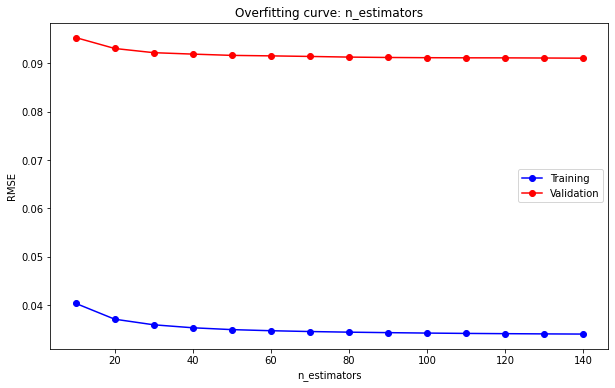

In [ ]:
# tuning n_estimators

test_param_and_plot('n_estimators', range(10, 150, 10)) # 90

Since `n_estimators` affect the training time of the model we can update the test_params() function so we can reduce the training time of the model.

In [ ]:
# updating the n_estimators in the function with the optimal value

def test_params(**params):
    model = RandomForestRegressor(n_estimators = 90, random_state = 100, n_jobs = -1, **params).fit(X_train_scaled, y_train)
    train_rmse = mean_squared_error(model.predict(X_train_scaled), y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val_scaled), y_val, squared=False)
    return train_rmse, val_rmse

#### max_depth

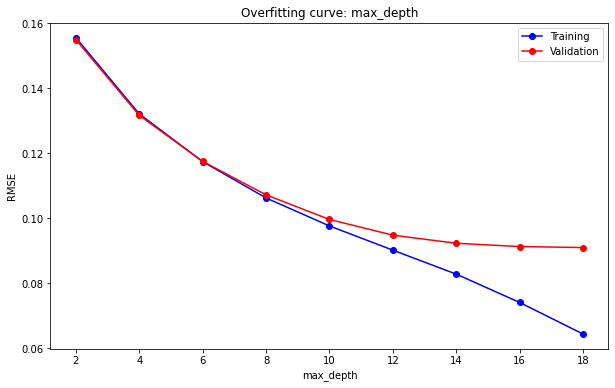

In [ ]:
# tuning max_depth

test_param_and_plot('max_depth', range(2, 20, 2)) #12

#### min_samples_split

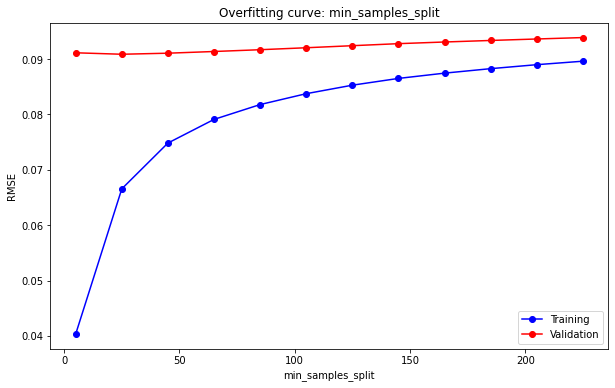

In [ ]:
# tuning min_samples_split

test_param_and_plot('min_samples_split', range(5, 226, 20)) # 10

#### max_features

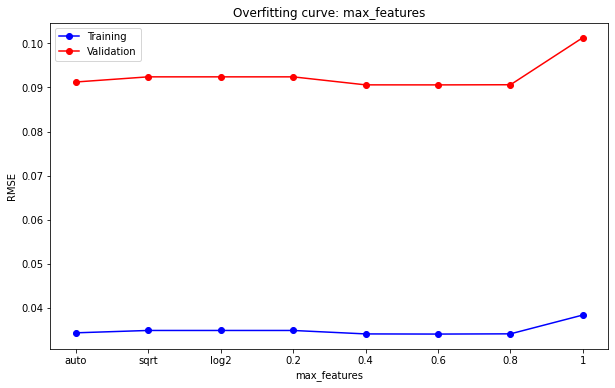

In [ ]:
# tuning max_features

test_param_and_plot('max_features', ['auto', 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8, 1]) # 0.4

#### max_leaf_nodes

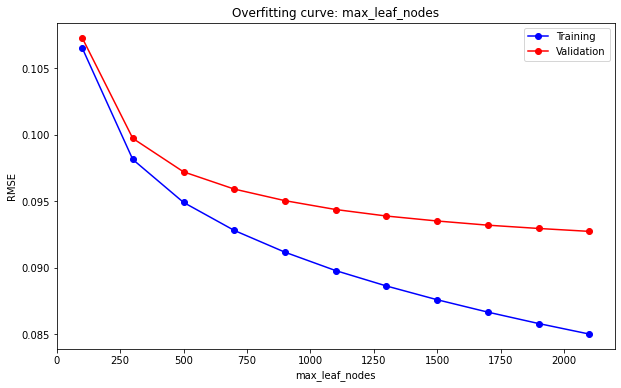

In [ ]:
# tuning max_leaf_nodes

test_param_and_plot('max_leaf_nodes', range(100, 2200, 200)) # 750

#### min_samples_leaf

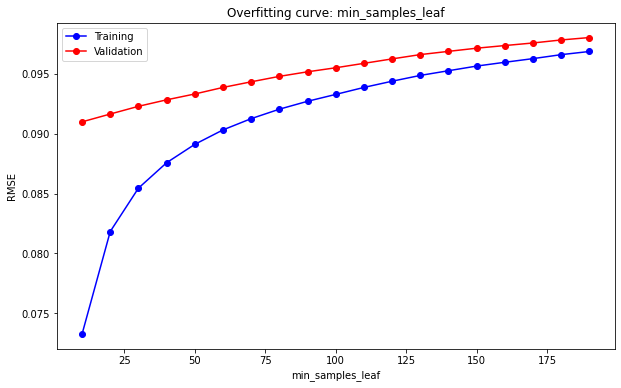

In [ ]:
# tuning min_samples_leaf

test_param_and_plot('min_samples_leaf', range(10, 200, 10)) # 10

#### max_samples

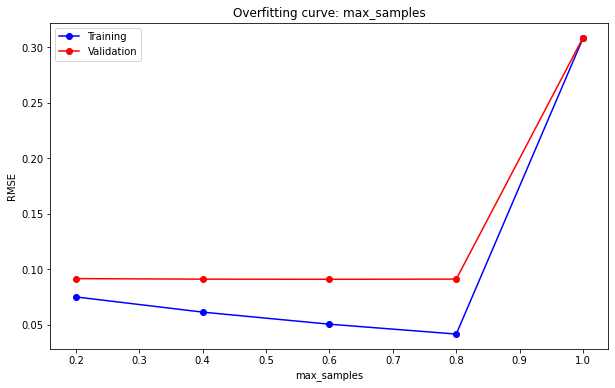

In [ ]:
# tuning max_samples

test_param_and_plot('max_samples', [0.2, 0.4, 0.6, 0.8, 1]) # 0.8

### Combining all the hyper parameters

Using the obtained hyper parametes values to redefine the model.

In [ ]:
model1 = RandomForestRegressor(n_estimators = 80, max_depth = 12, min_samples_split = 100,
                               max_features = 0.8, max_leaf_nodes = 2000, min_samples_leaf = 100,
                               max_samples = 0.8, n_jobs = -1, random_state = 100)
model1.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=12, max_features=0.8, max_leaf_nodes=2000,
                      max_samples=0.8, min_samples_leaf=100,
                      min_samples_split=100, n_estimators=80, n_jobs=-1,
                      random_state=100)

In [ ]:
# finding the predictions for X_train data
train_preds11 = model1.predict(X_train_scaled)

# error on the train data
train_rmse11 = mean_squared_error(train_preds11, y_train, squared = False)
print('The RMSE loss for the training data is {}'.format(train_rmse1))

The RMSE loss for the training data is 0.034204378025085934


In [ ]:
# making predictions in the validation data
val_preds12 = model1.predict(X_val_scaled)

# checking the error on the validation data
val_rmse12 = mean_squared_error(val_preds12, y_val, squared = False)
print('The RMSE loss for the validation data is {}'.format(val_rmse1))

The RMSE loss for the validation data is 0.09119824104093802


### Making predictions on the test data

In [ ]:
test_df.head()

,Id,groupId,matchId,damageDealt,DBNOs,killPlace,killPoints,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,health_items,totalDistance,killsWithoutMoving,teamwork,headshot_kill_rate
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,51.46,0,73,0,0,0.00,1884,squad,28,28,1500,0,0,0,1,0,0,588.0,False,0,0.000000
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,179.10,0,11,0,1,361.90,1811,duo,48,47,1503,0,0,0,6,0,6,6686.0,False,2,0.000000
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,23.40,0,49,0,0,0.00,1793,squad,28,27,1565,0,0,0,4,0,4,787.8,False,1,0.000000
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,65.52,0,54,0,0,0.00,1834,duo,45,44,1465,0,0,0,3,0,0,1812.0,False,0,0.000000
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,330.20,1,7,0,1,60.06,1326,squad,28,27,1480,0,0,0,4,0,5,2963.0,False,1,0.666667


In [ ]:
# dropping id columns on the test data

test_df_id = test_df[['Id','groupId','matchId']]
test_df.drop(columns = ['Id','groupId','matchId'], inplace = True)

In [ ]:
# encoding MatchType column using One Hot Encoding

encoder = OneHotEncoder()
encoder.fit(test_df[['matchType']])
encoder.categories_

[array(['duo', 'solo', 'squad'], dtype=object)]

In [ ]:
one_hot = encoder.transform(test_df[['matchType']]).toarray()
one_hot

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [ ]:
#storing the encoded values back in the dataframe

test_df[['duo', 'solo', 'squad']] = one_hot
test_df.drop(columns = ['matchType'], inplace = True)

In [ ]:
# scaling the numeric columns using StandardScaler

scaled_test_df = pd.DataFrame(scaler.transform(test_df), columns = test_df.columns)
scaled_test_df.head()

,damageDealt,DBNOs,killPlace,killPoints,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,roadKills,teamKills,vehicleDestroys,weaponsAcquired,winPoints,health_items,totalDistance,killsWithoutMoving,teamwork,headshot_kill_rate,duo,solo,squad
0,-0.468636,-0.57620,0.925979,-0.806232,-0.766477,-0.451080,1.181012,-0.691814,-0.643283,0.826941,-0.046614,-0.142435,-0.085366,-1.107503,-0.82145,-0.638489,-0.539399,0.0,-0.484509,-0.395179,-0.650078,-0.438909,0.920337
1,0.288242,-0.57620,-1.332514,-0.806232,0.641705,6.652943,0.898434,0.148452,0.173207,0.831012,-0.046614,-0.142435,-0.085366,0.977925,-0.82145,0.909530,2.264869,0.0,1.946590,-0.395179,1.538277,-0.438909,-1.086558
2,-0.635026,-0.57620,0.051723,-0.806232,-0.766477,-0.451080,0.828757,-0.691814,-0.686257,0.915144,-0.046614,-0.142435,-0.085366,0.143754,-0.82145,0.393524,-0.447518,0.0,0.731040,-0.395179,-0.650078,-0.438909,0.920337
3,-0.385263,-0.57620,0.233860,-0.806232,-0.766477,-0.451080,0.987465,0.022412,0.044287,0.779448,-0.046614,-0.142435,-0.085366,-0.273332,-0.82145,-0.638489,0.023478,0.0,-0.484509,-0.395179,1.538277,-0.438909,-1.086558
4,1.184233,0.29784,-1.478224,-0.806232,0.641705,0.727885,-0.978970,-0.691814,-0.686257,0.799802,-0.046614,-0.142435,-0.085366,0.143754,-0.82145,0.651527,0.552785,0.0,0.731040,2.168404,-0.650078,-0.438909,0.920337


In [ ]:
test_preds1 = model1.predict(scaled_test_df)

In [ ]:
prediction_df1 = test_df_id
prediction_df1['predictions'] = test_preds1
prediction_df1.head()

,Id,groupId,matchId,predictions
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0.242137
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0.911056
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,0.663274
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0.536160
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0.926655


## Model 2: XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model2 = XGBRegressor(random_state = 100, n_jobs = -1) # instance of xgboost regressor
model2.fit(X_train_scaled, y_train) # training the model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Making predictions and evaluating the model

In [ ]:
# finding the predictions for X_train data

train_preds2 = model2.predict(X_train_scaled)
train_preds2

array([0.23298833, 0.30307978, 0.21600032, ..., 0.14544149, 0.21560186,
       0.12326737], dtype=float32)

In [ ]:
# error on the train data

train_rmse2 = mean_squared_error(train_preds2, y_train, squared = False)
print('The RMSE loss for the training data is {}'.format(train_rmse2))

The RMSE loss for the training data is 0.08534542692825071


In [ ]:
# making predictions in the validation data

val_preds2 = model2.predict(X_val_scaled)
val_preds2

array([0.84600306, 0.50708365, 0.05822077, ..., 0.5779547 , 0.8494139 ,
       0.3362419 ], dtype=float32)

In [ ]:
# checking the error on the validation data

val_rmse2 = mean_squared_error(val_preds2, y_val, squared = False)
print('The RMSE loss for the validation data is {}'.format(val_rmse2))

The RMSE loss for the validation data is 0.08901914824572336


### Feature Importance

In [ ]:
feature_imp = pd.DataFrame({
    'Feature' : X_train.columns,
    'Importance' : model2.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

feature_imp.head(10)

,Feature,Importance
16,totalDistance,0.571863
2,killPlace,0.148908
4,killStreaks,0.057903
15,health_items,0.033341
21,solo,0.030472
1,DBNOs,0.029170
6,matchDuration,0.020979
8,numGroups,0.020941
7,maxPlace,0.016867
22,squad,0.014676


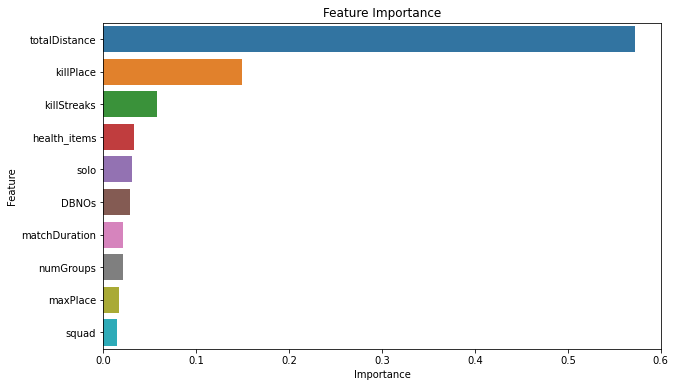

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data = feature_imp.head(10), x = 'Importance', y = 'Feature');

### Hyper Parameter Tuning

In [ ]:
# function that takes the different arguments and trains the RandomForestRegressor
# return the rmse of the training and validation data

def test_params(**params):
    model = XGBRegressor(random_state = 100, n_jobs=-1, **params).fit(X_train_scaled, y_train)
    train_rmse = mean_squared_error(model.predict(X_train_scaled), y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val_scaled), y_val, squared=False)
    return train_rmse, val_rmse

In [ ]:
# funcition to plot the training and validation error for the passed parameters
# using the test_params to find the training and validation error

def test_param_and_plot(param_name, param_values):
    train_rmse_ls, val_rmse_ls = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_rmse_ls.append(train_rmse)
        val_rmse_ls.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_rmse_ls, 'b-o')
    plt.plot(param_values, val_rmse_ls, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

#### n_estimators

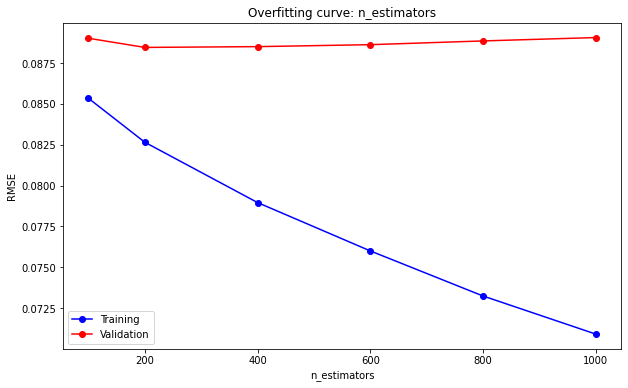

In [ ]:
# tuning n_estimators

test_param_and_plot('n_estimators', [100, 200, 400, 600, 800, 1000]) # 200

In [ ]:
# updating the n_estimators in the function with the optimal value

def test_params(**params):
    model = XGBRegressor(n_estimators = 200, random_state=100, n_jobs=-1, **params).fit(X_train_scaled, y_train)
    train_rmse = mean_squared_error(model.predict(X_train_scaled), y_train, squared=False)
    val_rmse = mean_squared_error(model.predict(X_val_scaled), y_val, squared=False)
    return train_rmse, val_rmse

#### max_depth

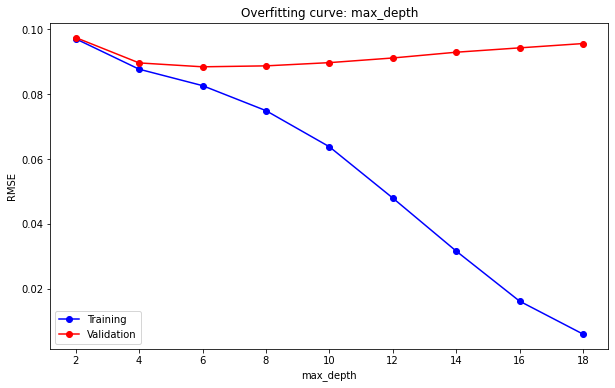

In [ ]:
# tuning max_depth

test_param_and_plot('max_depth', range(2, 20, 2)) #8

#### booster

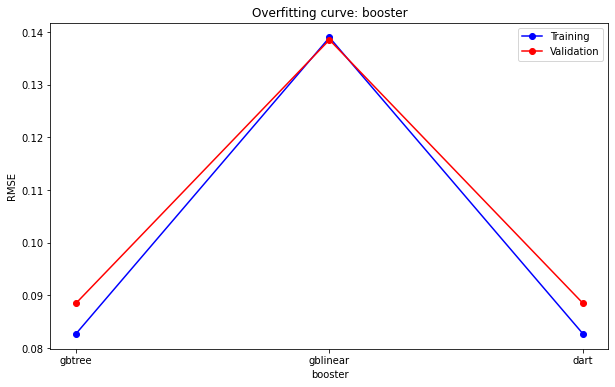

In [ ]:
# tuning booster

test_param_and_plot('booster', ['gbtree', 'gblinear', 'dart']) #gbtree

#### min_child_weight

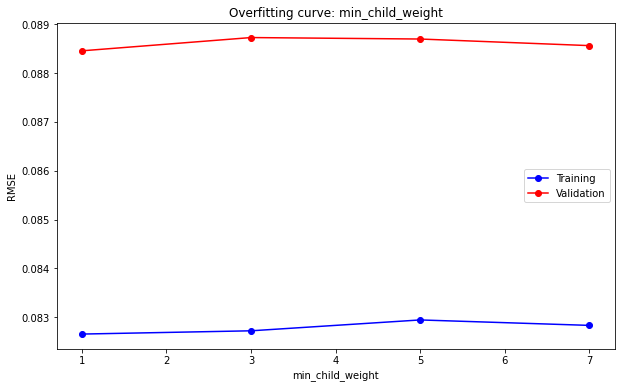

In [ ]:
# tuning min_child_weight

test_param_and_plot('min_child_weight', [1, 3, 5, 7]) # 1

#### colsample_bytree

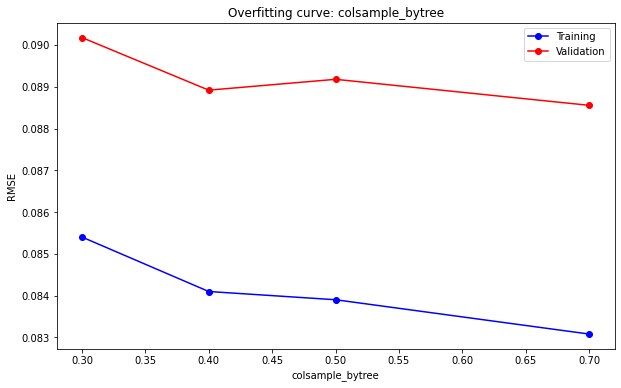

In [ ]:
# tuning colsample_bytree

test_param_and_plot('colsample_bytree', [0.3, 0.4, 0.5 , 0.7]) # 0.7

#### max_delta_step 

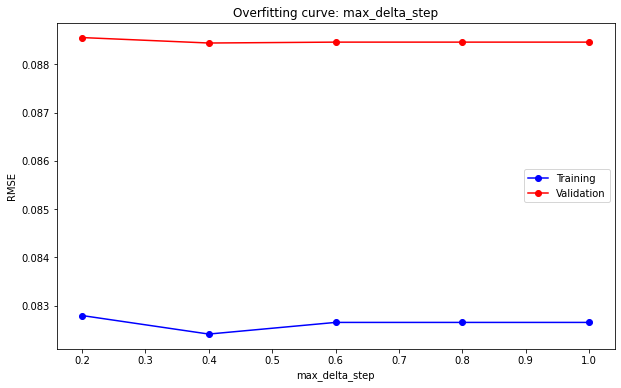

In [ ]:
# tuning max_delta_step

test_param_and_plot('max_delta_step', [0.2, 0.4, 0.6, 0.8, 1]) # 0.7

#### subsample 

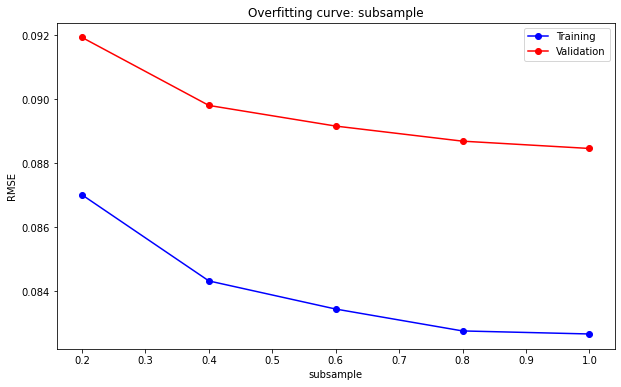

In [ ]:
# tuning subsample

test_param_and_plot('subsample', [0.2, 0.4, 0.6 , 0.8, 1]) 

#### gamma

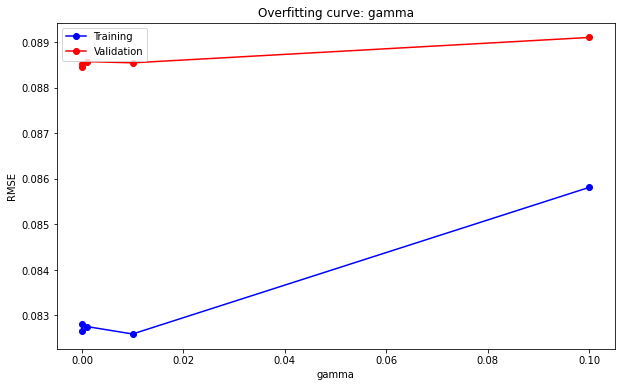

In [ ]:
# tuning gamma

test_param_and_plot('gamma', [0.00001, 0.0001, 0.001, 0.01, 0.1]) 

#### learning_rate

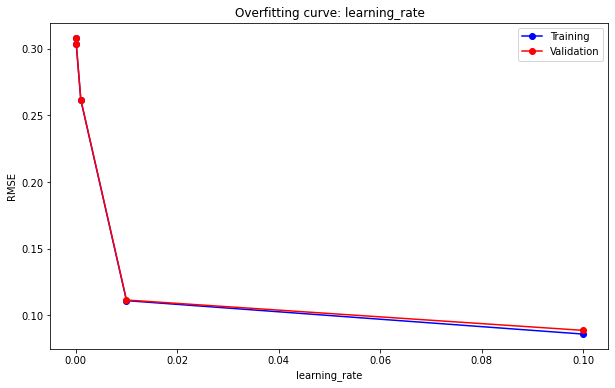

In [ ]:
# tuning learning_rate

test_param_and_plot('learning_rate', [0.00001, 0.0001, 0.001, 0.01, 0.1]) 

### Combining all the hyper parameters

Using the obtained hyper parametes values to redefine the model.

In [ ]:
model2 = XGBRegressor(n_estimators = 200, max_depth = 6, learning_rate = 0.1,
                      booster = 'gbtree', gamma = 0.1, min_child_weight = 5,
                      colsample_bytree = 0.7, subsample = 0.8, max_delta_step = 0.4,
                      n_jobs = -1, random_state = 100)

model2.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0.4,
             max_depth=6, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# finding the predictions for train data

train_preds21 = model2.predict(X_train_scaled)
print(train_preds21)
print()

# error on the train data

train_rmse21 = mean_squared_error(train_preds21, y_train, squared = False)
print('The RMSE loss for the training data is {}'.format(train_rmse2))

[0.23303787 0.32525343 0.20880923 ... 0.13808782 0.21560875 0.14951845]

The RMSE loss for the training data is 0.08534542692825071


In [ ]:
# making predictions in the validation data

val_preds22 = model2.predict(X_val_scaled)
print(val_preds22)
print()
# checking the error on the validation data

val_rmse22 = mean_squared_error(val_preds22, y_val, squared = False)
print('The RMSE loss for the validation data is {}'.format(val_rmse2))

[0.83012044 0.52010435 0.0558666  ... 0.5465879  0.8438819  0.3370505 ]

The RMSE loss for the validation data is 0.08901914824572336


### Prediction on test data

In [ ]:
test_preds2 = model2.predict(scaled_test_df)
test_preds2

array([0.24476771, 0.9583398 , 0.6635659 , ..., 0.8663189 , 0.8717282 ,
       0.07152939], dtype=float32)

In [ ]:
prediction_df2 = test_df_id
prediction_df2['predictions'] = test_preds2
prediction_df2.head()

,Id,groupId,matchId,predictions
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0.244768
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0.958340
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,0.663566
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0.517912
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0.924069


In [ ]:
random_forest = {'train_rmse(before_tuning)' : train_rmse1,
       'val_rmse(before_tuning)' : val_rmse1,
        'train_rmse(after_tuning)' : train_rmse11,
       'val_rmse(after_tuning)' : val_rmse12}
    
xgboost = {'train_rmse(before_tuning)' : train_rmse2,
       'val_rmse(before_tuning)' : val_rmse2,
        'train_rmse(after_tuning)' : train_rmse21,
       'val_rmse(after_tuning)' : val_rmse22}


In [ ]:
# data frame with the erroe values for both the models.

final_prediction = pd.DataFrame([random_forest, xgboost], index = ['Random_Forest_Regressor', 'XGBoost_Regressor'])
final_prediction

,train_rmse(before_tuning),val_rmse(before_tuning),train_rmse(after_tuning),val_rmse(after_tuning)
Random_Forest_Regressor,0.034204,0.091198,0.095100,0.096509
XGBoost_Regressor,0.085345,0.089019,0.086869,0.088963


In [ ]:
# data frame containing the prediction for both the models

prediction_df = test_df_id
prediction_df['Random_Forest_Prediction'] = test_preds1
prediction_df['XGBoost_Prediction'] = test_preds2
prediction_df.head()

,Id,groupId,matchId,predictions,Random_Forest_Prediction,XGBoost_Prediction
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0.244768,0.242137,0.244768
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0.958340,0.911056,0.958340
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,0.663566,0.663274,0.663566
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0.517912,0.536160,0.517912
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0.924069,0.926655,0.924069
